# Mushrooms classification

This notebook builds a predictive model for classify mushrooms between poisonous and edible, using the [Kaggle's Mushroom classification dataset](https://www.kaggle.com/uciml/mushroom-classification).

In [2]:
# Load dependencies.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import scipy.stats as ss

C:\Users\Jose\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 1. Load and clear data

In [3]:
# Load dataset and take a quick look into it.
mushrooms = pd.read_csv('./data/mushrooms.csv', sep=',')
mushrooms.head(10)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,n,m
7,e,b,y,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,s,m
8,p,x,y,w,t,p,f,c,n,p,...,s,w,w,p,w,o,p,k,v,g
9,e,b,s,y,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,s,m


In [4]:
# Check if they are cells with null or missing values.
mushrooms.isna().sum().any()

False

In [5]:
# Check how many unique values each column has.
for column in mushrooms.columns:
    print(column, mushrooms[column].unique())

class ['p' 'e']
cap-shape ['x' 'b' 's' 'f' 'k' 'c']
cap-surface ['s' 'y' 'f' 'g']
cap-color ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises ['t' 'f']
odor ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment ['f' 'a']
gill-spacing ['c' 'w']
gill-size ['n' 'b']
gill-color ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape ['e' 't']
stalk-root ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring ['s' 'f' 'k' 'y']
stalk-surface-below-ring ['s' 'f' 'y' 'k']
stalk-color-above-ring ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type ['p']
veil-color ['w' 'n' 'o' 'y']
ring-number ['o' 't' 'n']
ring-type ['p' 'e' 'l' 'f' 'n']
spore-print-color ['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population ['s' 'n' 'a' 'v' 'y' 'c']
habitat ['u' 'g' 'm' 'd' 'p' 'w' 'l']


In [6]:
# Remove the 'veil-type' column, since isn't useful.
mushrooms = mushrooms.drop(columns=['veil-type'])

In [7]:
# Convert the 'class' column to a numeric value.
mushrooms.loc[mushrooms['class'] == 'p', 'class'] = 1
mushrooms.loc[mushrooms['class'] == 'e', 'class'] = 0

## 2. Explore data

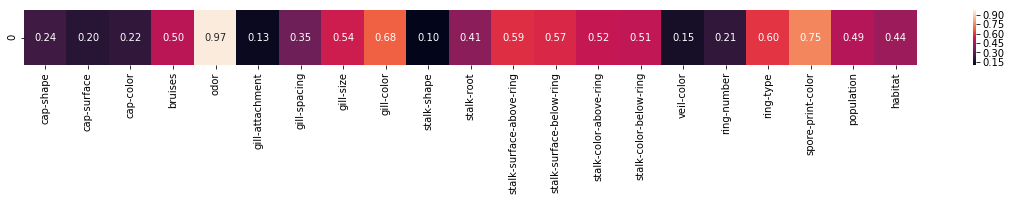

In [8]:
def cramers_v(confusion_matrix):
    """ Calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calculate correlations of columns with 'class'.
corrs_index = mushrooms.columns.tolist()
corrs_index.remove('class')
corrs = pd.Series([0.0] * len(corrs_index), index=corrs_index)

for column in corrs.index:
    confusion_matrix = pd.crosstab(mushrooms[column], mushrooms['class']).values
    corrs[column] = cramers_v(confusion_matrix)

# Draw heatmap.
plt.figure(figsize=(20,1))
sns.heatmap(corrs.to_frame().T, annot=True, fmt='.2f')
plt.show()

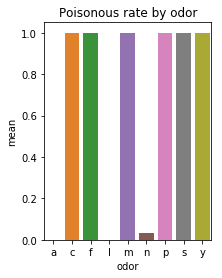

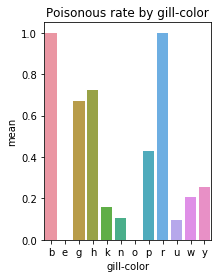

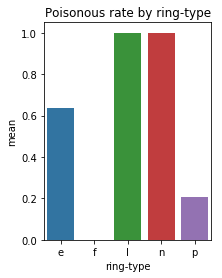

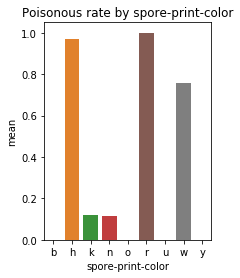

In [9]:
# Draw bar chars for each column whose correlation if superior to 0.6.
for column in corrs.index:
    if corrs[column] > 0.6:
        # Calculate poisonous rate for each value.
        column_stats = mushrooms[[column, 'class']].groupby(column).agg({'class': ['count', 'sum']})
        column_stats['mean'] = column_stats['class']['sum'] / column_stats['class']['count']
        
        # Draw bar chart.
        plt.figure(figsize=(3,4))
        plt.title("Poisonous rate by " + column)
        sns.barplot(x=column_stats.index, y=column_stats['mean'])

## 3. Build models

### 3.1 Simple decision tree and forest models

In [10]:
# Separate output from input columns.
X = mushrooms.drop('class', axis=1)
y = mushrooms['class'].copy()
y = y.astype('int')

# Convert categorical values into indicator variables.
X = pd.get_dummies(X)

# Separate data into training and testing subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [11]:
# Create and train a classifier using a decision tree.
mushroom_tree_classifier = DecisionTreeClassifier(max_leaf_nodes=7, random_state=0)
mushroom_tree_classifier.fit(X_train, y_train)

# Make predictions and check accuracy.
y_pred_dt = mushroom_tree_classifier.predict(X_test)
accuracy_score(y_true = y_test, y_pred = y_pred_dt)

0.9914211115255501

In [12]:
# Create and train a classifier using a random forest.
mushroom_forest_classifier = RandomForestClassifier(n_estimators=4, max_leaf_nodes=7, random_state=0)  
mushroom_forest_classifier.fit(X_train, y_train)

# Make predictions and check accuracy (again).
y_pred_rf = mushroom_forest_classifier.predict(X_test)  
accuracy_score(y_true = y_test, y_pred = y_pred_rf)

0.9574785527788139

### 3.2 Odor model

In [13]:
# Create a descision tree using only the odor as feature.
Xo = mushrooms['odor'].copy()
Xo = pd.get_dummies(Xo)
Xo_train, Xo_test, yo_train, yo_test = train_test_split(Xo, y, test_size=0.33, random_state=324)

odor_classifier = DecisionTreeClassifier(max_leaf_nodes=7, random_state=0)  
odor_classifier.fit(Xo_train, yo_train)

yo_pred_rf = odor_classifier.predict(Xo_test)  
accuracy_score(y_true = yo_test, y_pred = yo_pred_rf)

0.9858261842596047

### 3.3 Model without odor

In [14]:
# Check the accuracy when using all features except for odor.
Xno = mushrooms.drop('class', axis=1).drop('odor', axis=1)
Xno = pd.get_dummies(Xno)
Xno_train, Xno_test, yno_train, yno_test = train_test_split(Xno, y, test_size=0.33, random_state=324)

no_odor_classifier = DecisionTreeClassifier(max_leaf_nodes=7, random_state=0)  
no_odor_classifier.fit(Xno_train, yno_train)

yno_pred_rf = no_odor_classifier.predict(Xno_test)  
accuracy_score(y_true = yno_test, y_pred = yno_pred_rf)

0.9738903394255874

### 3.4 Handcrafted model

In [15]:
# Create a handcrafted model by defining filters for each mushroom hunting tips:
# 1. Choose mushrooms without white gills.
gills_tip = mushrooms['gill-color'] != 'w'

# 2. Select mushrooms without red on the cap or stem.
cap_color_tip = mushrooms['cap-color'] != 'r'
stem_tip = (mushrooms['stalk-color-above-ring'] != 'r') & (mushrooms['stalk-color-below-ring'] != 'r')

# 3. Look for mushrooms without scales on the cap.
cap_surface_tip = mushrooms['cap-surface'] != 'y'

# 4. Seek out mushrooms without a ring around the stem
ring_number_tip = mushrooms['ring-number'] == 'n'

# Combine filters and make predictions.
hunt_filter = gills_tip & cap_color_tip & stem_tip & cap_surface_tip
hunt_pred = np.where(hunt_filter == True, 0, 1)

# Check accuracy.
accuracy_score(y_true = y, y_pred = hunt_pred)

0.5046774987690793